<a href="https://colab.research.google.com/github/hawaiie-star/UrbanSimulation/blob/main/automl/automl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mljar-supervised

This workflow is really simple..

In [2]:
# import libraries
import pandas as pd
import numpy as np

from supervised.automl import AutoML

In [3]:
# make sure we can see the plots
%matplotlib inline

In [4]:
# mount to Google Drive so we can import the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# read in the data wherever you stored it
df = pd.read_csv("drive/MyDrive/migration.csv")

In [6]:
# or you can read it in from github
# df = pd.read_csv("https://github.com/asrenninger/urbansim/raw/main/automl/migration.csv.gz")

In [7]:
# I'm listing the columns so below I can see what I want to keep
df.columns

Index(['code_i', 'code_j', 'F_ij', 'distance', 'name_i', 'name_j', 'density_i',
       'married_i', 'households_i', 'population_i', 'nonwhite_i',
       'unhealthy_i', 'employed_i', 'university_i', 'density_j', 'married_j',
       'households_j', 'population_j', 'nonwhite_j', 'unhealthy_j',
       'employed_j', 'university_j'],
      dtype='object')

In [8]:
print(df.shape)
print(df.columns)
print(df.head(3))
print(df["F_ij"].describe())

(88927, 22)
Index(['code_i', 'code_j', 'F_ij', 'distance', 'name_i', 'name_j', 'density_i',
       'married_i', 'households_i', 'population_i', 'nonwhite_i',
       'unhealthy_i', 'employed_i', 'university_i', 'density_j', 'married_j',
       'households_j', 'population_j', 'nonwhite_j', 'unhealthy_j',
       'employed_j', 'university_j'],
      dtype='object')
      code_i     code_j  F_ij  distance                name_i         name_j  \
0  E06000001  E06000002   140  8.853261            Hartlepool  Middlesbrough   
1  E06000003  E06000002   939  8.107915  Redcar and Cleveland  Middlesbrough   
2  E06000004  E06000002   971  4.505858      Stockton-on-Tees  Middlesbrough   

   density_i  married_i  households_i  population_i  ...  employed_i  \
0      985.5   0.422567      2.255998         92338  ...    0.408813   
1      557.1   0.439966      2.215030        136530  ...    0.407383   
2      959.3   0.455623      2.347211        196593  ...    0.439726   

   university_i  density_j

AutoML has several modes— **Explain, Perform, Compete**. They all use different combinations of models to create the best prediction. The lightest, fastest possible collection of models is Explain, so we will stick with that to make it run faster.

In [9]:
# create training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # we are going to throw out the first 2 columns
    df[df.columns[3:]], df["F_ij"], test_size=0.25
)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="drive/MyDrive/automl", mode='Explain')
# fit the model
automl.fit(X_train, y_train)

Linear algorithm was disabled.
This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


See that AutoML saves the model as to your folder. Go to the directory and check out the model. There should be Feature Importance images in each model folder. These compute the "importance" of each variable by shuffling them one-by-one and seeing how much a completely random version hurts model performance. What are some important features?

In [10]:
# let's store predictions
y_pred = automl.predict(X_test)

There are lot of model evaluation metrics in [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [11]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score
# percent error
print(mean_absolute_percentage_error(y_test, y_pred))
# absolute error
print(median_absolute_error(y_test, y_pred))
# r-squared
print(r2_score(y_test, y_pred))

1.9710192348908722
6.254819115730993
0.7312192152882028


Why do you think these are useful metrics, compared to something like RMSE?

In [12]:
# bin the predictions so we can see which parts of the distribution we are predicting best with
y_eval = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
y_eval['quantile'] = pd.qcut(y_eval['y_test'], 10, duplicates='drop')
y_eval['quantile'] = y_eval['quantile'].apply(lambda x: x.mid)

/tmp/ipython-input-1186874090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


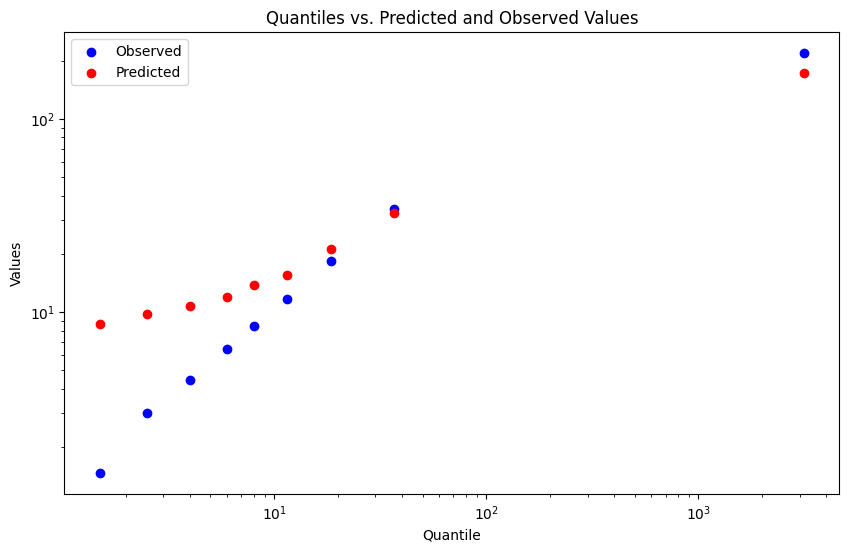

In [13]:
# average error per quantile
y_tile = y_eval.groupby('quantile', as_index=False).agg({'y_pred': 'mean', 'y_test': 'mean'})

import matplotlib.pyplot as plt
# sort the DataFrame by decile for plotting
y_tile.sort_values('quantile', inplace=True)

# create a figure and an axes instance
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot for observed values on ax
ax.scatter(y_tile['quantile'], y_tile['y_test'], color='blue', label='Observed')

# scatter plot for predicted values on ax
ax.scatter(y_tile['quantile'], y_tile['y_pred'], color='red', label='Predicted')

# adding labels and legend
ax.set_xlabel('Quantile')
ax.set_ylabel('Values')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

# show plot
plt.show()

It seems like we are predicting well everywhere except the low end of the distribution

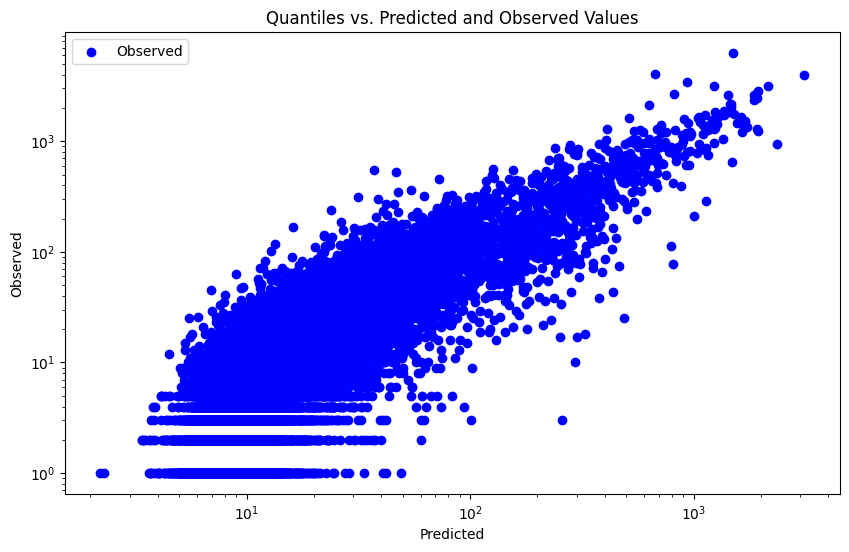

In [14]:
# predictions against observations
y_eval.sort_values('quantile', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_eval['y_pred'], y_eval['y_test'], color='blue', label='Observed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

plt.show()

In [15]:
df.shape

(88927, 22)

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

158.29597459912708


# Challenge

Create a new folder called "perform", then run AutoML again with a new results_path but instead of "Explain" use "Perform" as its mode. This will use more models in the stacking and should get better results. Show some metrics from `sklearn`and plot some results; can you show that the new "Perform" model did better or worse?

In [ ]:
# create training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # we are going to throw out the first 2 columns
    df[df.columns[3:]], df["F_ij"], test_size=0.25
)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="perform_local", mode="Perform") # create "perform folder" and use "Perform" mode

# fit the model
automl.fit(X_train, y_train)

In [33]:
from supervised.automl import AutoML

automl_perform = AutoML(results_path="drive/MyDrive/perform_local")

In [34]:
# let's store predictions
y_pred = automl.predict(X_test)

 ### Mean Absolute Percentage, Error Median Absolute Error, R2 score

In [35]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score
# percent error
print(mean_absolute_percentage_error(y_test, y_pred))
# absolute error
print(median_absolute_error(y_test, y_pred))
# r-squared
print(r2_score(y_test, y_pred))

1.0496036487726583
3.623937405892436
0.8660918714930514


In [36]:
# bin the predictions so we can see which parts of the distribution we are predicting best with
y_eval = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
y_eval['quantile'] = pd.qcut(y_eval['y_test'], 10, duplicates='drop')
y_eval['quantile'] = y_eval['quantile'].apply(lambda x: x.mid)

### Quantiles vs. Predicted and Observed Values

/tmp/ipython-input-1186874090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


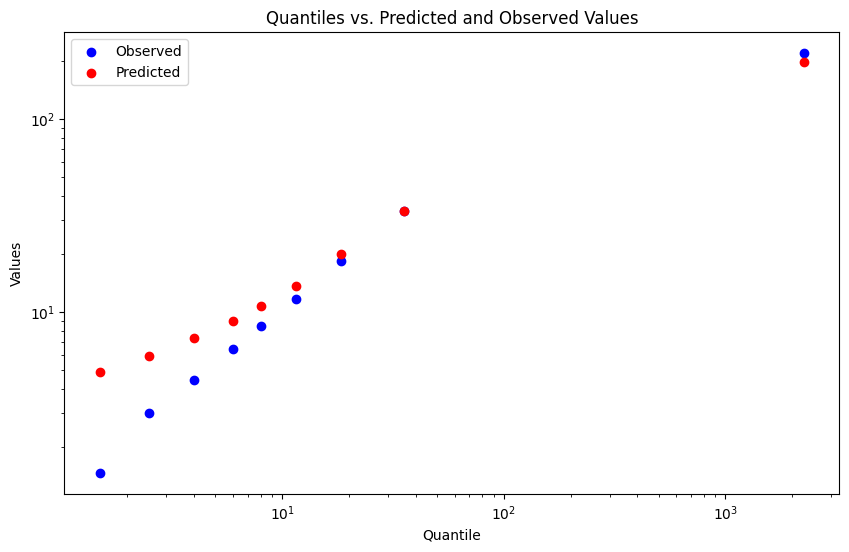

In [37]:
# average error per quantile
y_tile = y_eval.groupby('quantile', as_index=False).agg({'y_pred': 'mean', 'y_test': 'mean'})

import matplotlib.pyplot as plt
# sort the DataFrame by decile for plotting
y_tile.sort_values('quantile', inplace=True)

# create a figure and an axes instance
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot for observed values on ax
ax.scatter(y_tile['quantile'], y_tile['y_test'], color='blue', label='Observed')

# scatter plot for predicted values on ax
ax.scatter(y_tile['quantile'], y_tile['y_pred'], color='red', label='Predicted')

# adding labels and legend
ax.set_xlabel('Quantile')
ax.set_ylabel('Values')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

# show plot
plt.show()

This plot breaks the test data into groups from low flows to high flows. Blue is what actually happened, red is what the model predicted. If the red dots sit close to the blue dots, the model is doing well. Here, you can see it slightly overpredicts the smallest flows, but it matches the medium and large flows pretty closely.

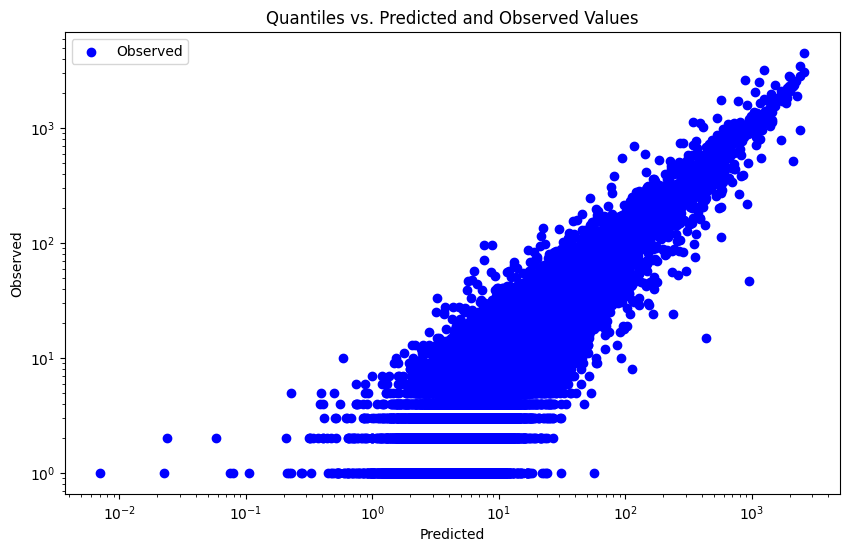

In [38]:
# predictions against observations
y_eval.sort_values('quantile', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_eval['y_pred'], y_eval['y_test'], color='blue', label='Observed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

plt.show()

Each dot is a flow. The closer the points follow the diagonal trend, the better the model. Perform mode aligns more closely and matches the improved metrics, so it performs better overall.

## Discussion
Did the new "Perform" model did better or worse compared to the "Explain" mode?

In [39]:
automl_explain = AutoML(results_path="drive/MyDrive/automl", mode="Explain")
automl_explain.fit(X_train, y_train)
y_pred_explain = automl_explain.predict(X_test)

Linear algorithm was disabled.
This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


In [40]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score

def metrics(y_test, y_pred):
    return {
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "MedianAE": median_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

print("Explain:", metrics(y_test, y_pred_explain))
print("Perform:", metrics(y_test, y_pred))

Explain: {'MAPE': 1.9306709890351685, 'MedianAE': 6.137163933846227, 'R2': 0.7802764938350725}
Perform: {'MAPE': 1.0496036487726583, 'MedianAE': 3.623937405892436, 'R2': 0.8660918714930514}


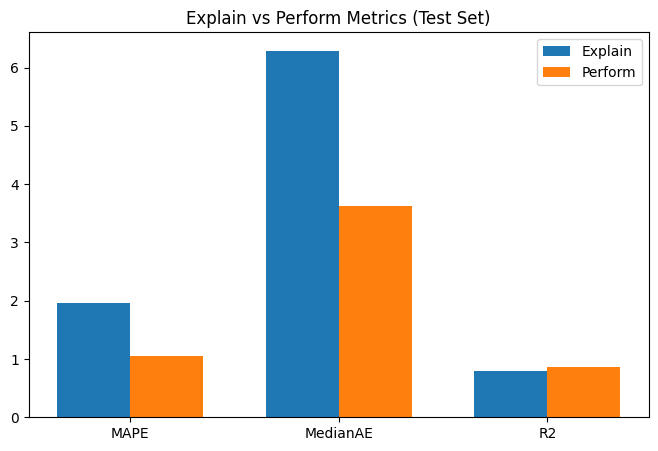

In [41]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["MAPE", "MedianAE", "R2"]
explain = [1.960012015965903, 6.290522584053747, 0.7859987074660899]
perform = [1.0496036487726583, 3.623937405892436, 0.8660918714930514]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, explain, width, label="Explain")
plt.bar(x + width/2, perform, width, label="Perform")
plt.xticks(x, metrics)
plt.title("Explain vs Perform Metrics (Test Set)")
plt.legend()
plt.show()

> Perform mode did better (YAYYY!!!) than Explain mode because it achieved lower percentage error, lower median absolute error, and higher R² on the same test set.

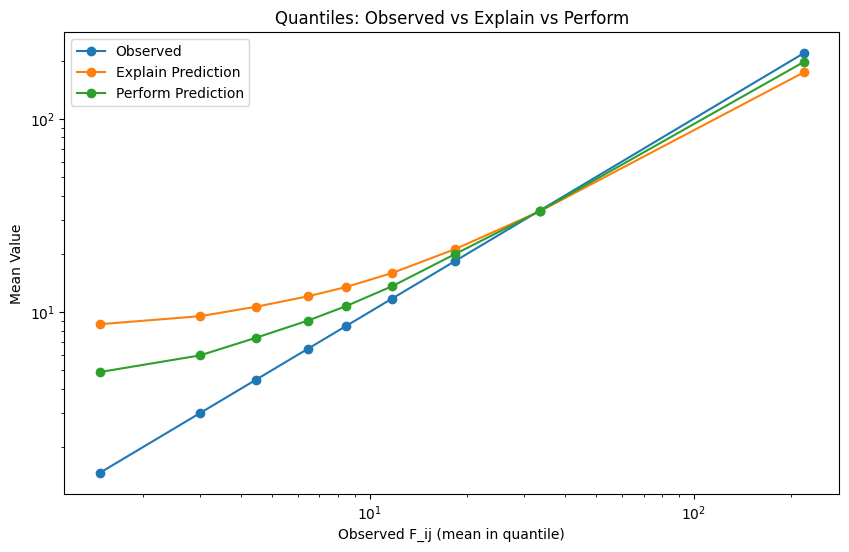

In [47]:
plt.figure(figsize=(10,6))

plt.plot(tile["y_test"], tile["y_test"], marker="o", label="Observed")
plt.plot(tile["y_test"], tile["Explain"], marker="o", label="Explain Prediction")
plt.plot(tile["y_test"], tile["Perform"], marker="o", label="Perform Prediction")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Observed F_ij (mean in quantile)")
plt.ylabel("Mean Value")
plt.title("Quantiles: Observed vs Explain vs Perform")
plt.legend()
plt.show()


>From the above, we can see Explain consistently overpredicts the small flows, while Perform is much closer to the real values. For the largest flows, both models become similar, but overall Perform tracks the observed values better.


Explain mode only uses simpler models so it is easier to interpret, while Perform mode uses a wider range of models and stronger stacking to maximise accuracy, and therefore the error values are lower.